# DeepFalcon Task 1: jet Pt regression



I'll start by importing all the libraries I'm going to use and setting random seeds for reproducible results:

In [1]:
import pyarrow.parquet as pq
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import torch.optim as optim
from torchvision.models import resnet18
from glob import glob

np.random.seed(42)
torch.manual_seed(42)

And defining some environment variables such as the path to the dataset:

In [2]:
JETS_DIR = '../input/gsoc-2022-eval/Boosted_Jets_Samples'
QUARK_GLUON_DIR = '../input/e2equark-gluons'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_WORKERS = 2

## The data

### Exploring the data

We can initially check out some of the data that we have available, loading one of the parquet datasets:

In [3]:
example = pq.ParquetFile(os.path.join(JETS_DIR, 'Boosted_Jets_Sample-0.snappy.parquet'))
example.metadata

  created_by: parquet-cpp version 1.5.1-SNAPSHOT
  num_columns: 1
  num_rows: 32000
  num_row_groups: 32000
  format_version: 1.0
  serialized_size: 4164717

In [4]:
example.schema

required group field_id=-1 schema {
  optional group field_id=-1 X_jets (List) {
    repeated group field_id=-1 list {
      optional group field_id=-1 item (List) {
        repeated group field_id=-1 list {
          optional group field_id=-1 item (List) {
            repeated group field_id=-1 list {
              optional double field_id=-1 item;
            }
          }
        }
      }
    }
  }
}

We have only 1 column over here, composed of a list of lists. The task asks us to perform regression though, which would mean we need a target...

Let's check the data out a bit better by using the same data loading pipeline designed by [Ali Hariri on last year's GSoC](https://github.com/ML4SCI/DeepFalcon/tree/main/GNN_for_Fast_Detector_Simulation_Ali_Hariri).

In [5]:
example_row = example.read_row_group(0)
example_dict = example_row.to_pydict()
example_dict.keys()

dict_keys(['X_jets'])

Indeed we only have one column. Exploring the dataset we can see that the elements in this one column are 3x125x125 images:

(3, 125, 125)


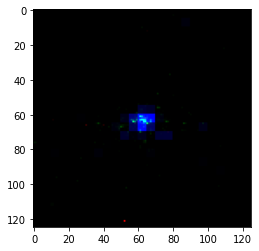

In [6]:
example_data = np.float32(example_dict['X_jets'][0])
print(example_data.shape)
plt.imshow(example_data.transpose(1,2,0))

Based on last year's GSoC code, [Graph Generative Models for Fast Detector Simulations in Particle Physics paper](https://ml4physicalsciences.github.io/2020/files/NeurIPS_ML4PS_2020_138.pdf) and [End-to-End Physics Event Classification with CMS Open Data](https://arxiv.org/abs/1807.11916), we have that each channel of the image represent a different detector stage:

0. Tracker: constructed as a 2D histogram of the track reconstructed position at perigee in ECAL or HCAL geometry.
1. ECAL: reconstructed hit energies and ECAL crystal coordinates.
2. HCAL: reconstructed hit energies versus HCAL tower coordinates.

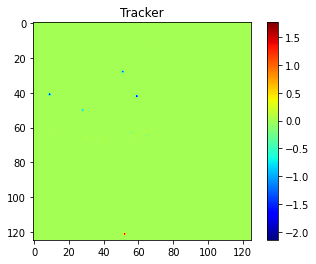

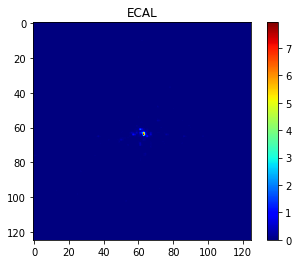

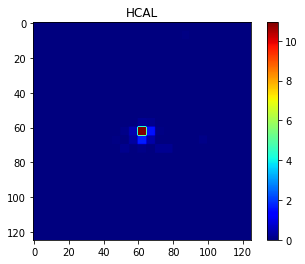

In [7]:
plt.imshow(example_data[0], cmap='jet')
plt.title('Tracker')
plt.colorbar()
plt.show()

plt.imshow(example_data[1], cmap='jet')
plt.title('ECAL')
plt.colorbar()
plt.show()

plt.imshow(example_data[2], cmap='jet')
plt.title('HCAL')
plt.colorbar()
plt.show()

Due to the lack of a target variable however, I'm not able to perform the the regression task on this dataset to infer the transverse momentum (Pt) of the top quark events.

### A new dataset!

Since I wasn't able to find the "real dataset" for this task with the target variables I searched around for other datasets on tasks of other projects that were similar to this one.

Luckily, I found a very similar one! Thus, I'm going to be using the "Quark-Gluon Classification" dataset, intended for the E2E project. While it is intended for classification between quarks and gluons, it contains a column very similar to our `'X_jets'` and also a Pt columns for the transverse momentum. We can explore an example:

In [8]:
example = pq.ParquetFile(os.path.join(QUARK_GLUON_DIR, 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'))
example.metadata

  created_by: parquet-cpp version 1.3.1-SNAPSHOT
  num_columns: 4
  num_rows: 36272
  num_row_groups: 36272
  format_version: 1.0
  serialized_size: 14143781

In [9]:
example_row = example.read_row_group(0)
example_dict = example_row.to_pydict()
print(example_dict.keys())

example_dict['pt']

dict_keys(['X_jets', 'pt', 'm0', 'y'])


[112.41109466552734]

(3, 125, 125)


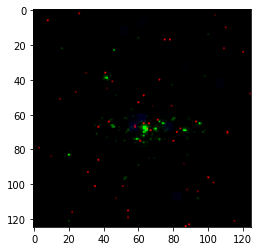

In [10]:
example_data = np.float32(example_dict['X_jets'][0])
print(example_data.shape)
plt.imshow(example_data.transpose(1,2,0))

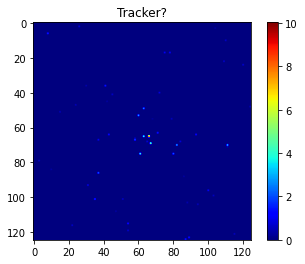

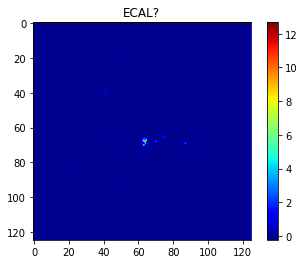

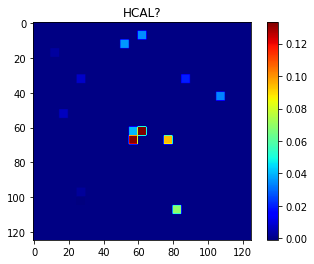

In [11]:
plt.imshow(example_data[0], cmap='jet')
plt.title('Tracker?')
plt.colorbar()
plt.show()

plt.imshow(example_data[1], cmap='jet')
plt.title('ECAL?')
plt.colorbar()
plt.show()

plt.imshow(example_data[2], cmap='jet')
plt.title('HCAL?')
plt.colorbar()
plt.show()

Looks pretty similar to what we got in terms of resolution!

One problem is that while we have the labels that say wether a given data point is a quark or a gluon, we don't know if label 0 represents quarks or gluons. As such, in order to not make false assumptions, I'm going to use the whole dataset, with both `y=0` and `y=1`.

### Dataset and dataloaders

It is also helpful to create custom PyTorch dataloaders in order to load the data more efficiently during training, without the need of loading it all at once on memory (which is not computationally feasible with my resources).

After trying lots of different methods with PyArrow and Dask to read partitioned parquet files efficiently, I wasn't able to come up with a clean way of doing so. Thus I made a hacky method that opens the next file if we've reached the end of the current file:

In [12]:
class JetDataset(Dataset):
    def __init__(self, parquet_files, transform=None, data_target_cols=['X_jets', 'pt']):
        self.parquets = []
        
        # open each parquet file and count the number of rows
        cumrows = 0
        for f in parquet_files:
            parquet = pq.ParquetFile(f)
            rows = parquet.num_row_groups
            cumrows += rows
            self.parquets.append((parquet, rows, cumrows))
            
        self.transform = transform
        self.data_target_cols = data_target_cols
        
    def __len__(self):
        return sum([i[1] for i in self.parquets])
    
    def __getitem__(self, idx):
        # check in which parquet file the `idx` is in and use that file to load data
        for parquet, rows, cumrows in self.parquets:
            if idx < cumrows:
                break
            else:
                continue
                
        # read data
        idx = idx - (cumrows - rows)
        row = parquet.read_row_group(idx, columns=self.data_target_cols).to_pydict()
        data = np.float32(row['X_jets'][0])
        target = np.float32(row['pt'])
        
        # zero suppression
        data[data < 1.e-3] = 0.
        
        # apply transforms to the data (we're already turning the data to a PyTorch tensor)
        if self.transform:
            data = self.transform(torch.from_numpy(data))
            
        return data, torch.tensor(target)

I'm not going to be employing any kind of data augmentation or transforms. I believe more information regarding the origins of the data would be needed for me to do so.

### Splitting train/val/test

I'm not going to be employing any kind of data augmentation or transforms. I believe more information regarding the origins of the data would be needed for me to do so.

In [13]:
parquet_files = glob(os.path.join(QUARK_GLUON_DIR, '*.parquet'))

train_dataset = JetDataset(parquet_files)
val_dataset = JetDataset(parquet_files)
test_dataset = JetDataset(parquet_files)

In [14]:
len(train_dataset) # == len(val_dataset) == len(test_dataset)

139306

It is common practice to split the data into three datasets: train/val/test. Since we have so much data, we don't need to have that much of a percentage of our data in our validation and test sets. Thus, I'm going to be using a train/val/test split of 95/2.5/2.5, this way we're able to have even more training data, while still having pretty sizable validation and test sets:

In [15]:
train_size = 0.95

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

In [16]:
print('train dataset size:', len(train_data), 'percentage of train dataset:', len(train_data) / len(train_dataset))
print('val dataset size:', len(val_data), 'percentage of val dataset:', len(val_data) / len(train_dataset))
print('test dataset size:', len(test_data), 'percentage of test dataset:', len(test_data) / len(train_dataset))

train dataset size: 132340 percentage of train dataset: 0.9499949750908073
val dataset size: 3483 percentage of val dataset: 0.025002512454596355
test dataset size: 3483 percentage of test dataset: 0.025002512454596355


We can now create the dataloaders that will be used for training, validation and testing:

In [17]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

## Modeling the regression problem

We're trying to infer a continuous value based on an image. This is very similar to [one of last year's DeepLense GSoC projects](https://github.com/ML4SCI/DeepLense/tree/main/DeepLense_Regression_Yurii_Halychanskyi) that revolved around predicting the axion mass density of galaxies.

### Arquitecture

On this project, a custom-made XResNet model was able to achieve a very good performance on the lensing dataset. However, the model is quite computationally demanding and would take a long time to train, especially when considering the dimensions of our training dataset.

As such, I'm going to be simplifying the model, using a model with less parameters based on a ResNet18 architecture:

In [18]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)
        
    def forward(self, x):
        x = self.resnet(x)
        return x

However, I'm going to be using the same loss function used in the DeepLense regression project:

In [19]:
def mse_loss_wgtd(pred, true, wgt=1.):
    loss = wgt*(pred-true).pow(2)
    return loss.mean()

def root_mean_squared_error(pred, true): 
    return torch.sqrt(mse_loss_wgtd(pred.view(-1), true.view(-1)))

### Training and evaluation loops

Now all we need is to define how our model will be trained and evaluated. For demonstration purposes I'm going to make the hyperparameters fixed. I'll also be using the validation dataset for early stopping.

In [20]:
def evaluate(model, dataloader):
    # set network to evaluation mode
    model.eval()
    
    mae = nn.L1Loss() # mean absolute error
    running_error = 0.0
    
    target_list = []
    outputs_list = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            
            # predict
            outputs = model(data)
            
            running_error += mae(outputs, target).item()
            
            # add target and prediction to a list (numpify them)
            target_numpy = target.detach().cpu().numpy()
            outputs_numpy = outputs.detach().cpu().numpy()

            # append
            target_list.append(target_numpy)
            outputs_list.append(outputs_numpy)

        # get error over whole dataset
        error = running_error / len(dataloader)
            
        # get targets and predictions
        target_list = np.concatenate(target_list)
        outputs_list = np.concatenate(outputs_list)
            
    return error, target_list, outputs_list
    

def train(model, train_dataloader, val_dataloader, epochs):
    # hyperparameters and optimizer
    criterion = root_mean_squared_error
    mae = nn.L1Loss() # mean absolute error
    lr = 1e-3
    wd = 1e-5
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # early stopping variables
    best_error = np.inf # ideal error == 0
    patience = 5 # stops training if error doesn't improve in 5 epochs
    bad_epochs = 0
    
    # metrics
    history = {'train_loss': [], 'train_error': [], 'val_error': []}
    
    # train
    for epoch in range(epochs):
        # set network to training mode
        model.train()

        running_loss = 0.0
        running_error = 0.0

        for data, target in train_dataloader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)

            # zero gradients
            optimizer.zero_grad()

            # infer and get loss
            outputs = model(data)
            loss = criterion(outputs, target)

            # backpropagate and update weights
            loss.backward()
            optimizer.step()

            # metrics
            running_loss += loss.item()
            running_error += mae(outputs, target).item()

        # get metrics
        epoch_loss = running_loss / len(train_dataloader)
        epoch_error = running_error / len(train_dataloader)
        history['train_loss'].append(epoch_loss)
        history['train_error'].append(epoch_error)

        # evaluate on validation data
        val_epoch_error, _, _ = evaluate(model, val_dataloader)
        history['val_error'].append(val_epoch_error)

        # save checkpoint
        if val_epoch_error < best_error:
            torch.save({'model_weights': model.state_dict()}, './model_task1.pt')
            best_error = val_epoch_error
            bad_epochs = 0

        else:
            bad_epochs += 1

        print('[Epoch {}/{}] loss: {:.6f}; error: {:.6f}; val error: {:.6f};'.format(epoch+1, epochs, epoch_loss, epoch_error, val_epoch_error))

        if bad_epochs >= patience:
            print(f"reached {bad_epochs} bad epochs, stopping training with best val error of {best_error}!")
            break

    best = torch.load('./model_task1.pt')
    model.load_state_dict(best['model_weights'])

    return model, history

## Training the model

Now we just need to train our regression model!

In [21]:
resnet = ResNet()
resnet = resnet.to(DEVICE)

resnet, history = train(resnet, train_dataloader, val_dataloader, epochs=7)

[Epoch 1/7] loss: 16.309219; error: 13.176284; val error: 25.955746;
[Epoch 2/7] loss: 10.751765; error: 8.196427; val error: 9.547487;
[Epoch 3/7] loss: 10.184888; error: 7.778432; val error: 28.305865;
[Epoch 4/7] loss: 9.785813; error: 7.487418; val error: 7.940570;
[Epoch 5/7] loss: 9.578882; error: 7.323832; val error: 6.981833;
[Epoch 6/7] loss: 9.362573; error: 7.157742; val error: 8.445538;
[Epoch 7/7] loss: 9.181320; error: 7.027284; val error: 6.718502;


We can also look at the training metrics in order to see how it evolves over time:

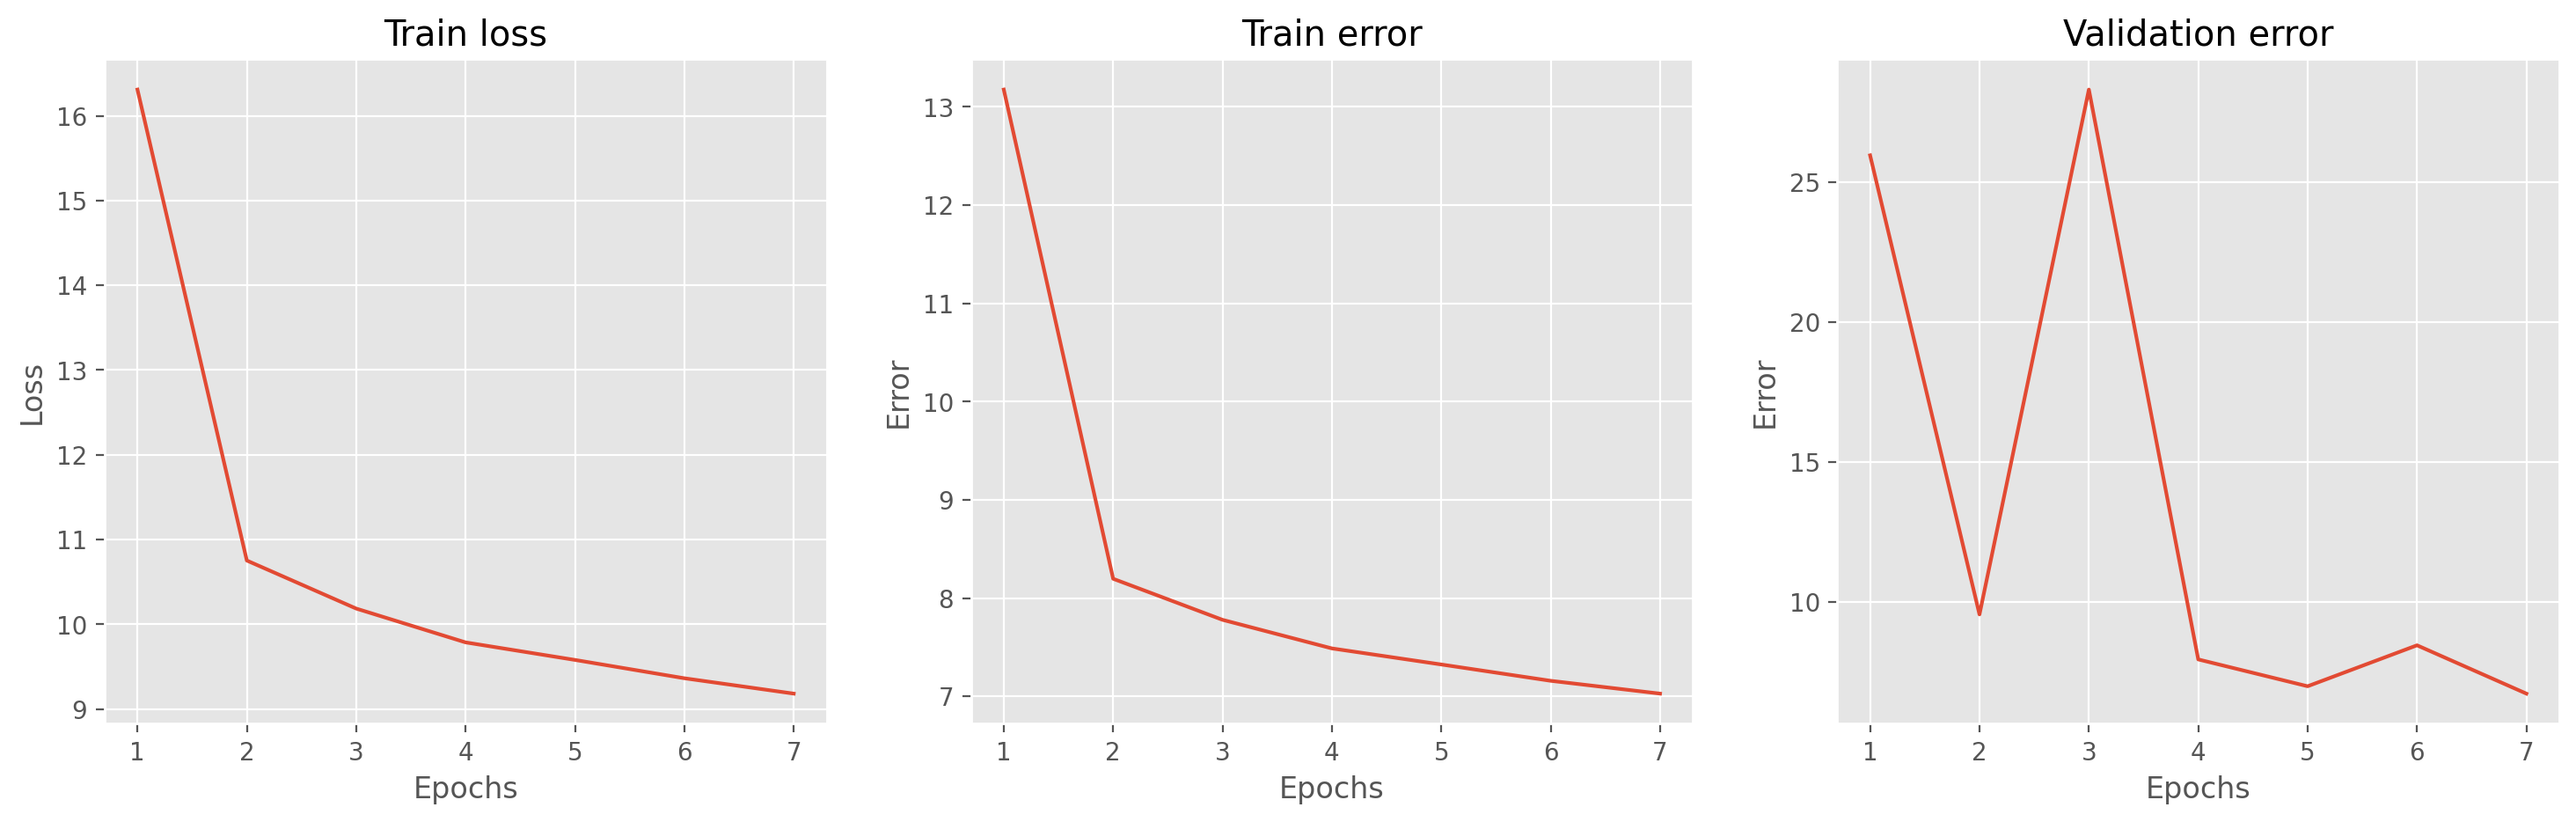

In [22]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200)

epochs = len(history['train_loss'])

axs[0].plot(range(1, epochs+1), history['train_loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train loss')

axs[1].plot(range(1, epochs+1), history['train_error'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Error')
axs[1].set_title('Train error')

axs[2].plot(range(1, epochs+1), history['val_error'])
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Error')
axs[2].set_title('Validation error')

plt.show()

## Evaluating the model

The error of the model on the test set is given by:

In [23]:
error, target_list, outputs_list = evaluate(resnet, test_dataloader)
error

6.568910425359553

We can also check out how our predictions compare to the actual values with:

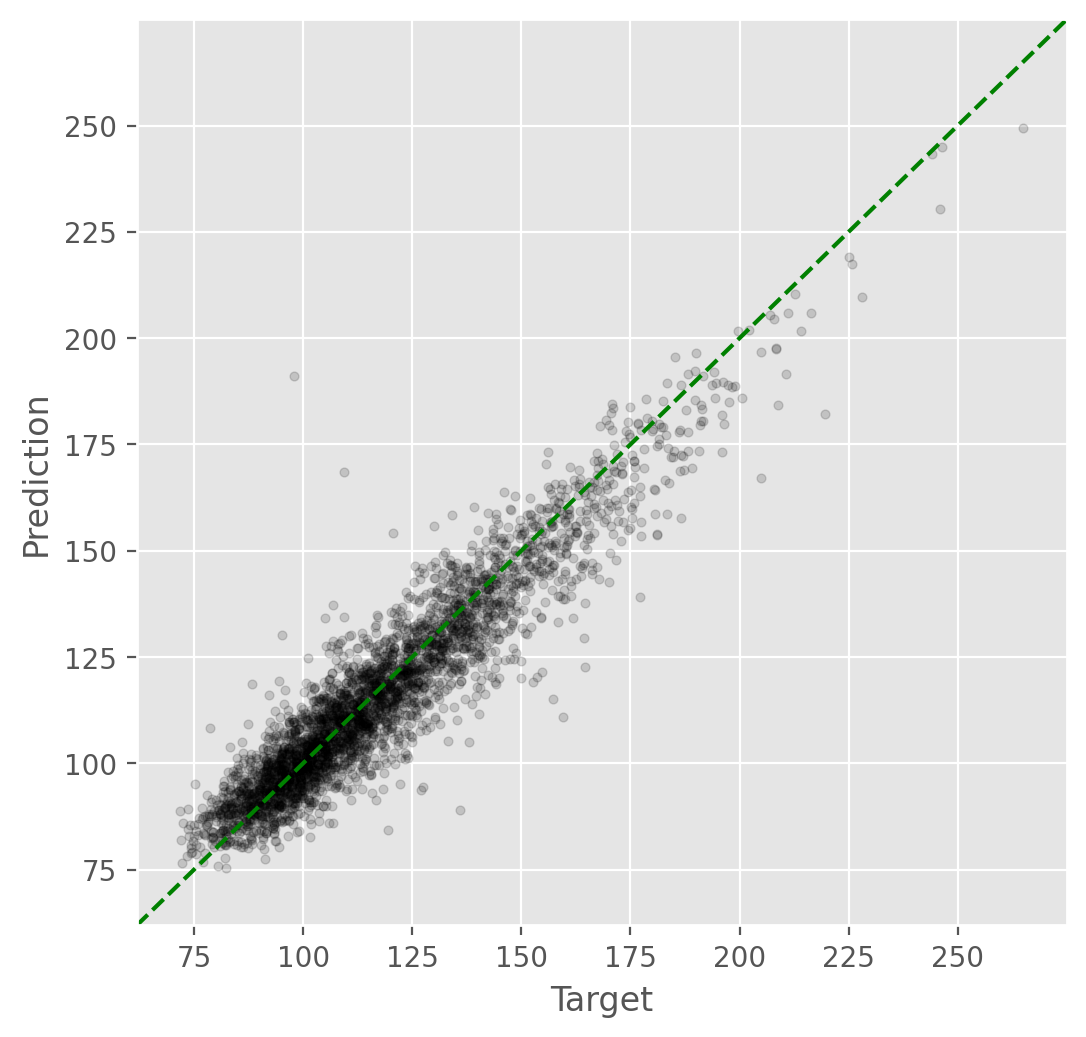

In [24]:
plt.figure(figsize=(6,6), dpi=200)

plt.scatter(target_list, outputs_list, color='black', alpha=0.15, s=10)

min_value = min(target_list) - 10
max_value = max(target_list) + 10
corrrect = np.linspace(min_value, max_value, 100)
plt.plot(corrrect, corrrect, color='green', ls='--')

plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)

plt.xlabel('Target')
plt.ylabel('Prediction')

plt.show()

## Conclusion

We can see that the model learns to predict the transverse momentum (Pt)! However, there are many ways that we could improve this model:

- **Use the actual top quark regression dataset**: it'd need to contain the Pt targets.
- **Preprocess the data**: applying other preprocessing steps particular to our data could help the model. I've supressed zeros, but there's probably a lot more that could be done, including data augmentation. This is where domain knowledge comes in.
- **Use a more robust model for regression**: we could use models such as the XResNet-based model that was used on last year's DeepLense GSoC project given that their architecture is geared towards conserving useful information for regression problems.
- **Train for longer**: I trained the model for only 7 epochs as a proof-of-concept and also to not exceed Kaggle's runtime (since the dataset is HUGE and I'm training on all of it, each epoch takes a while), but training it for longer would be highly beneficial.
- **Perform a hyperparameter search**: testing different optimizers, loss functions, learning rates and learning rate schedulers would help us squeeze the best performance we can get out of our model.